In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
import rubin_sim
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline
rubin_sim.__version__

'1.3.2'

In [9]:
from os import path

opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
print(f"Using {run_name}, to be read from {opsim_fname}")
# TODO: update to v3.3
# opsim_fname is being pulled from a rubin_sim command - Heather is going to update this.

Using baseline_v2.1_10yrs, to be read from /global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db


In [14]:
# Plot wish-list:
# After cutting to extragalactic WFD area, we want the following:
#   - Distribution of i-band coadd M5 values (ExgalM5WithCuts - applies the cuts mentioned above) at each data release from year 1 - year 10 (DR2-DR11)
#   - Later we want all bands, not just i
#   - Is there something for coadded PSF size?  Need to check.  Unclear.  Definitely has things for individual exposures.
# We want to be able to compare across different axes:
#   - For a given strategy, compare distributions at various years.
#   - For a given year, compare distributions across strategies.
#   - for a given year and strategy, compare distributions across bands.
# Ultimately we might summarize these in terms of a std or some percentile range.

## Let's start with a simple metric bundle of only the coaddm5 metric
Remember that the list of metrics is here: https://rubin-sim.lsst.io/rs_maf/metric_list.html

In [20]:
# Replicate of Rachel's function 
def run_Coaddm5(opsim_name, slicer, filter):
    
    depth_map_bundle = maf.MetricBundle(
    metric=maf.Coaddm5Metric(),
    slicer=slicer,
    constraint="filter='%s'"%filter,
    run_name=opsim_fname.split('/')[-1][0:-3],
    )

    bgroup = maf.MetricBundleGroup(
        [depth_map_bundle], opsim_fname
    )

    bgroup.run_all()
    bgroup.plot_all(closefigs=False)
    

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
filter='i'


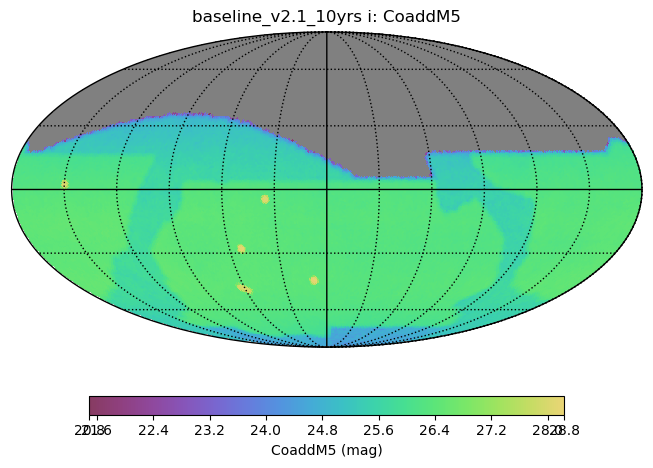

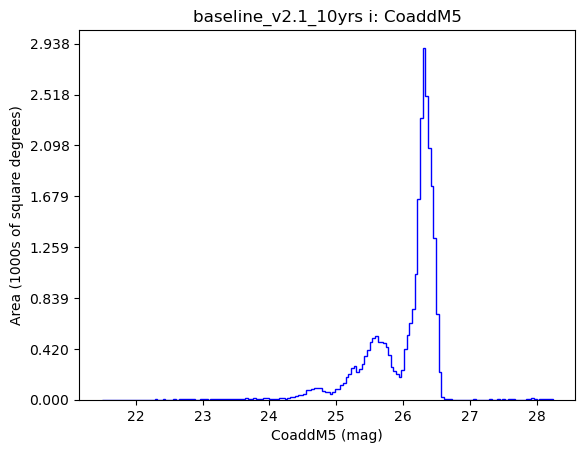

In [21]:
slicer=maf.HealpixSlicer(nside=64)
filter='i'
run_Coaddm5(opsim_fname, slicer, filter)

filter='i'


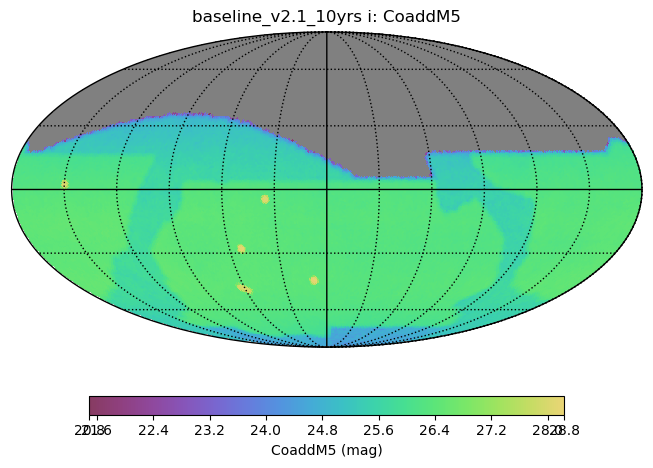

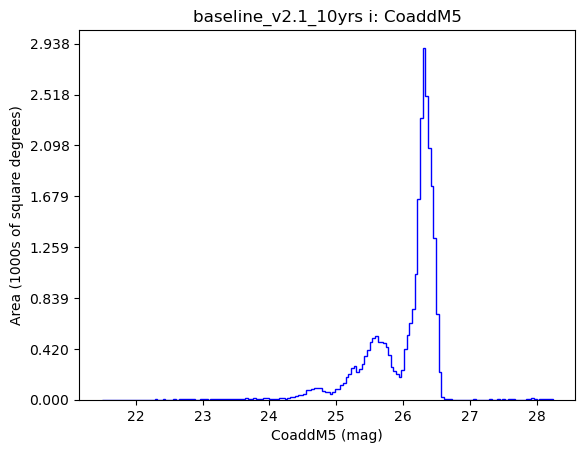

In [22]:
new_opsim_fname = '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db'
run_Coaddm5(new_opsim_fname, slicer, filter)

In [20]:
# TODO: add cut to "extragalactic area"
# Can add different metrics etc. to this bundle
# Need to figure out how to get intermediate years rather than full 10 years (follow Lynne's example)
depth_map_bundle = maf.MetricBundle(
    metric=maf.Coaddm5Metric(),
    slicer=maf.HealpixSlicer(nside=64),
    constraint="filter='i'",
    run_name=run_name,
)

bgroup = maf.MetricBundleGroup(
    [depth_map_bundle], opsim_fname
)
bgroup.run_all()
bgroup.plot_all(closefigs=False)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


[<rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle object at 0x7fdac263c210>, <rubin_sim.maf.metric_bundles.metric_bundle.MetricBundle object at 0x7fdacb8902d0>]


1

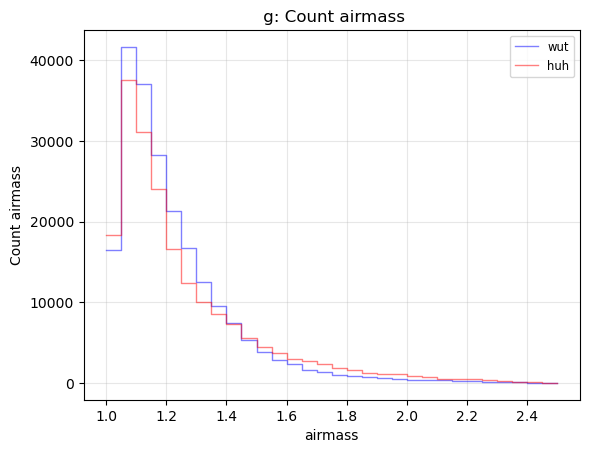

In [61]:
## Original example not in a combined function

from os.path import splitext, basename
data_dir = './'


example1_constraint = "filter = 'g'"
example1_slicer = maf.OneDSlicer(
    slice_col_name="airmass", bin_min=1.0, bin_max=2.5, bin_size=0.05
)
example1_metric = maf.CountMetric(col="airmass")
example1_bundle = maf.MetricBundle(
    example1_metric,
    example1_slicer,
    example1_constraint,
    run_name=run_name,
)

example1_bg = maf.MetricBundleGroup(
    [example1_bundle], opsim_fname, out_dir=data_dir
)
example1_bg.run_all()


example2_constraint = "filter = 'g'"
example2_slicer = maf.OneDSlicer(
    slice_col_name="airmass", bin_min=1.0, bin_max=2.5, bin_size=0.05
)
example2_metric = maf.CountMetric(col="airmass")
example2_bundle = maf.MetricBundle(
    example2_metric,
    example2_slicer,
    example2_constraint,
    run_name=new_opsim_fname,
)
example2_bg = maf.MetricBundleGroup(
    [example2_bundle], new_opsim_fname
)
example2_bg.run_all()

# bundle_list = []
# bundle_list.append(maf.MetricBundle(stuff))

example2_ph = maf.PlotHandler()

print([example1_bundle, example2_bundle])
example2_ph.set_metric_bundles([example1_bundle, example2_bundle])
plot_dicts = [
    {"label": 'wut', "color": "b"},
    {"label": 'huh', "color": "r"},
]

example2_ph.plot(plot_func=maf.OneDBinnedData(), plot_dicts=plot_dicts)

In [92]:
try:
   nside=64
   surveyAreas = SkyAreaGenerator(nside=nside)
   map_footprints, map_labels = surveyAreas.return_maps()
except:
    pass

def compare_opsim_metric_plot(use_run_name_vec, use_opsim_fname_vec, use_metric=maf.ExgalM5(), use_color_min=23, use_color_max=28):
    # use_run_name says which OpSim DB we want to use, e.g. `baseline_v2.1_10yrs` - will also be used for labels
    # use_opsim_fname says where it lives, e.g. `/global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db`
    constraint="filter='i'"
    #slicer=maf.HealpixSlicer(nside=nside, use_cache=False)
    slicer = maf.OneDSlicer(slice_col_name="seeingFwhmEff", bin_min=0.0, bin_max=2.5, bin_size=0.05)
    depth_map_bundle = []
    cols=['r','g','k']
    plot_dicts=[]
    for count,name in enumerate(use_run_name_vec):
#        print(f"using {name} on {use_opsim_fname_vec[count]}")
        bundle_item = maf.MetricBundle(
            metric=use_metric,
            slicer=slicer,
            constraint=constraint,
            run_name=name)

        bg_bundle = maf.MetricBundleGroup([bundle_item], use_opsim_fname_vec[count], out_dir=data_dir)
        bg_bundle.run_all()
        plot_dict_entry = {"label": name, "color": cols[count]}
        depth_map_bundle.append(bundle_item)
        plot_dicts.append(plot_dict_entry)

 #   print(depth_map_bundle)
    combined_plots = maf.PlotHandler()
 #   print(plot_dicts)
    
    combined_plots.set_metric_bundles(depth_map_bundle)
    combined_plots.plot(plot_func=maf.OneDBinnedData(), plot_dicts=plot_dicts)

    return combined_plots

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/slicers/one_d_slicer.py:102: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices. A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


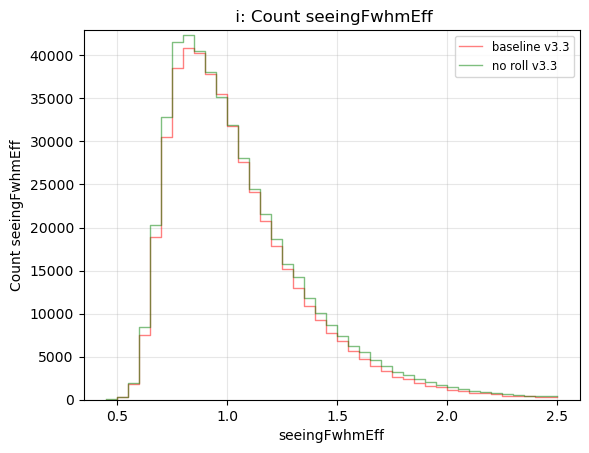

In [93]:
use_run_name_vec=['baseline v3.3','no roll v3.3']
use_opsim_fname_vec = [rubin_sim.data.get_baseline(),'/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db']
metric = maf.CountMetric(col="seeingFwhmEff")
compare_opsim_metric_plot(use_run_name_vec, use_opsim_fname_vec, use_metric=metric, use_color_min=23, use_color_max=28)